# Install the required library
! pip install robustness

In [1]:
%matplotlib inline
import os,sys
import matplotlib.pyplot as plt
sys.path.insert(0, './core/')
plt.rcParams['figure.figsize'] = [10, 2]

The number of samples is 96000
Pixel value range is from 0.0 to 1.0.


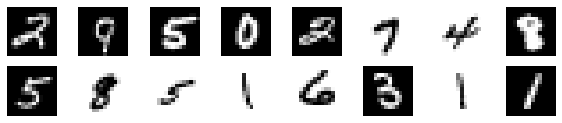

The number of samples is 24000
Pixel value range is from 0.0 to 1.0.


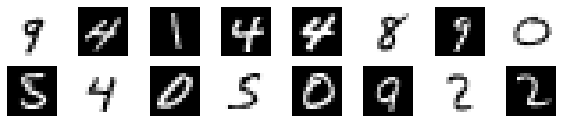

The number of samples is 20000
Pixel value range is from 0.0 to 1.0.


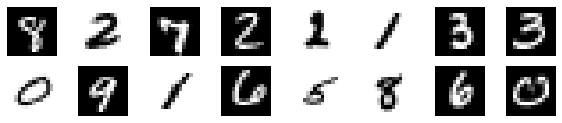

The number of samples is 20000
Pixel value range is from 0.0 to 1.0.


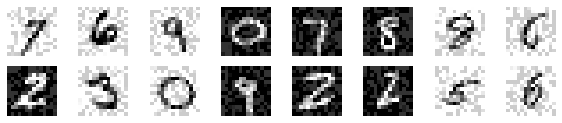

The number of samples is 20000
Pixel value range is from 0.0 to 1.0.


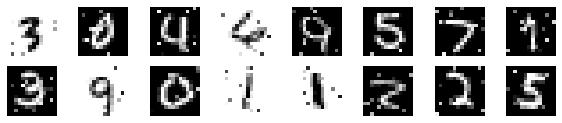

The number of samples is 300
Pixel value range is from 0.012532615102827549 to 1.0.


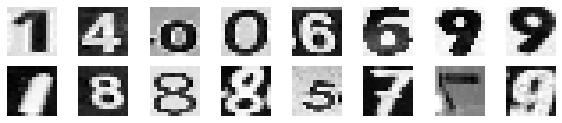

The number of samples is 300
Pixel value range is from 0.0022745097521692514 to 0.9899942874908447.


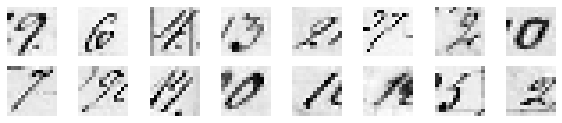

In [2]:
# load all digits datasets
import numpy as np
import loader
from functools import partial
from copy import deepcopy

mnist_dir = './data/digits/mnist'
ch74_dir = './data/digits/chars74k'
dida_dir = './data/digits/dida'
NUM_PER_CLASS = 30
DOWN_SAMPLE = True
testing = True

def visualize_imgs(img_array, rows = 2, cols = 8, selected = None):
    if DOWN_SAMPLE:
        process = lambda x:x.reshape(14,14)
    else:
        process = lambda x:x.reshape(28,28)
    if selected is None:
        assert(img_array.shape[0] >= rows * cols)
        selected = np.random.choice(img_array.shape[0], rows * cols, replace = False)
    else:
        assert(selected.size >= rows * cols)
        
    k = 1
    fid = plt.figure()
    for i in range(rows):
        for j in range(cols):
            plt.subplot(rows, cols, k)
            plt.imshow(process(img_array[selected[k-1]]), cmap='gray' )
            k += 1
            plt.axis('off')
    plt.show()
    
mnist_train, mnist_test = loader.read_mnist(mnist_dir, down_sample = DOWN_SAMPLE, with_label = False)
ch74 = loader.read_chars74k(ch74_dir, NUM_PER_CLASS)
ch74 = np.array(list(map(partial(loader.transform_to_mnist, down_sample = DOWN_SAMPLE, normalize = False) ,ch74)))
dida = loader.read_dida(dida_dir, NUM_PER_CLASS)
dida = np.array(list(map(partial(loader.transform_to_mnist, down_sample = DOWN_SAMPLE, normalize = True) ,dida)))

# augment mnist dataset for both black and white background
mnist_train = np.vstack([mnist_train, 1-mnist_train])
np.random.shuffle(mnist_train)
mnist_test =  np.vstack([mnist_test, 1-mnist_test])
np.random.shuffle(mnist_test)

# split full train set into train and validation
train_ratio = 0.8
train_size = int( mnist_train.shape[0] * train_ratio )
mnist_train, mnist_val = mnist_train[:train_size], mnist_train[train_size:] 

# do some jittering to the pixels of mnist_test
mnist_adv_gaussain = deepcopy(mnist_test)
mnist_adv_gaussain += np.clip(np.random.normal(size = mnist_adv_gaussain.shape, scale = 0.5), -0.2, 0.2)
mnist_adv_gaussain = np.clip(mnist_adv_gaussain, 0, 1)

n_jitter_pixel = 10
mnist_adv_pixel = deepcopy(mnist_test)
for item in mnist_adv_pixel:
    selected = np.random.choice(item.size, size = n_jitter_pixel, replace = False)
    item[selected] = np.random.uniform( size = selected.size )

# visulize the datasets
for dataset in [mnist_train, mnist_val, mnist_test, mnist_adv_gaussain, mnist_adv_pixel , ch74, dida]:
    print('The number of samples is {}'.format(dataset.shape[0]))
    assert(np.all(0 <= dataset) and np.all(dataset <= 1))
    print(f"Pixel value range is from {np.min(dataset)} to {np.max(dataset)}.")
    visualize_imgs(dataset)

if testing:
    mnist_train = mnist_train[:1000]

In [16]:
import torch
import torchvision.transforms as tvt
from robustness.datasets import DataSet
from robustness import cifar_models

class MNIST_Dataset(DataSet):
    def __init__(self, data_path='/tmp/', **kwargs):
        ds_kwargs = {
            'num_classes': 10,
            'mean': torch.tensor([0., 0., 0.]),
            'std': torch.tensor([1., 1., 1.]),
            'custom_class': None,
            'label_mapping': None, 
            'transform_train': [tvt.CenterCrop, tvt.ColorJitter],
            'transform_test': [tvt.CenterCrop, tvt.ColorJitter]
        }
        ds_kwargs = self.override_args(ds_kwargs, kwargs)
        super(MNIST_Dataset, self).__init__('mnist', data_path, **ds_kwargs)

    def get_model(self, arch, pretrained):
        if pretrained:
            raise ValueError('CIFAR does not support pytorch_pretrained=True')
        return cifar_models.__dict__[arch](num_classes=self.num_classes)

In [20]:
from cox.utils import Parameters
import cox.store
from robustness import model_utils, train, defaults
ds = MNIST_Dataset(data_path = './')
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds)
train_loader, val_loader = ds.make_loaders(batch_size=10, workers=1)

==> Preparing dataset mnist..


ValueError: Test data must be stored in dataset/test or ./test

In [ ]:
train_kwargs = {
    'out_dir': "train_out",
    'adv_train': 1,
    'constraint': '2',
    'eps': 0.5,
    'attack_lr': 0.1,
    'attack_steps': 7,
    'epochs': 5
}
train_args = Parameters(train_kwargs)

# Fill whatever parameters are missing from the defaults
train_args = defaults.check_and_fill_args(train_args,
                        defaults.TRAINING_ARGS, CIFAR)
train_args = defaults.check_and_fill_args(train_args,
                        defaults.PGD_ARGS, CIFAR)

In [ ]:
! pip install git+https://github.com/MadryLab/robustness.git